In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl

%matplotlib inline
import matplotlib
import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioSignal
from src import utils as ut

In [2]:
babble = AudioSignal(os.path.join(os.getcwd(), '../Exercise6', 'AudioFiles', 'SpeechBabble.wav'))
white = AudioSignal(os.path.join(os.getcwd(), '../Exercise6', 'AudioFiles', 'SpeechWhite.wav'))
clean = AudioSignal(os.path.join(os.getcwd(), '../Exercise2', 'AudioFiles', 'speech1.wav'))

Successfully loaded audio signal from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise6/AudioFiles/SpeechBabble.wav
Successfully loaded audio signal from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise6/AudioFiles/SpeechWhite.wav
Successfully loaded audio signal from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise2/AudioFiles/speech1.wav


# 1 Noise Power Estimation

In [3]:
b_stft, b_freq_axis_hz, b_frame_centers_ms = babble.compute_stft(frame_length_ms=32, frame_shift_ms=16, window_name='hann')
w_stft, w_freq_axis_hz, w_frame_centers_ms = white.compute_stft(frame_length_ms=32, frame_shift_ms=16, window_name='hann')
c_stft, c_freq_axis_hz, c_frame_centers_ms = clean.compute_stft(frame_length_ms=32, frame_shift_ms=16, window_name='hann')

## 1.1 Compute the posterior probability of speech presence

In [4]:
def compute_posterior_prob(Y: np.ndarray):
    
    # set theta to 15 dB
    theta_db = ut.db_to_lin(15)
    
    # init P
    L, K =  Y.shape
    P = np.zeros((L, K), dtype=np.float64)
    
    # init the estimated noise PSD
    noise_power_estimate = np.zeros((L + 1, K), dtype=np.float64)
    # init the -1th estimate with the first few frames of Y
    noise_power_estimate[-1, :] = np.mean(np.abs(Y[:30, :]) ** 2)
    
    # init smoothed posterior
    Q = np.zeros((L + 1, K), dtype=np.float64)
    
    
    alpha = 0.9
    beta = 0.8
    
    # init estimated noise psd (periodogram)
    N = np.zeros((L, K))
    
    for k in range(K):
        for l in range(L):
            # 1.1 posterior probability of speech presence (SPP)
            a = -(np.abs(Y[l, k]) ** 2) / noise_power_estimate[l-1, k]
            b = theta_db / (1 + theta_db)
            x = a * b
            P[l, k] = 1 / (1 + (1 + theta_db) * np.exp(x))
            
            # 1.2  smoothed posterior probability
            Q[l, k] = alpha * Q[l-1, k] + (1 - alpha) * P[l, k]
            if Q[l, k] > .99:
                P[l, k] = np.min((.99, P[l, k]))
            
            # 1.3 Estimate the noise periodogram
            N[l, k] = P[l, k] * noise_power_estimate[l-1, k] + (1 - P[l, k]) * (np.abs(Y[l, k]) ** 2)
            
            # update the noise power density
            noise_power_estimate[l, k] = beta * noise_power_estimate[l-1, k] + (1 - beta) * N[l, k]

    return P, noise_power_estimate

b_P, b_noise_power_estimate = compute_posterior_prob(b_stft)
w_P, w_noise_power_estimate = compute_posterior_prob(w_stft)
    

### 1.2 Plot the speech presence probability P (H1|Y [k, l])

In [5]:
def plot_spp(P, duration_s, min_freq = 0, max_freq = 8000):
    fig, ax = plt.subplots(1)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    im = ax.imshow(P.T,
                   origin='lower',
                   extent=[0, duration_s, min_freq, max_freq],
                   aspect='auto')

    fig.colorbar(im)

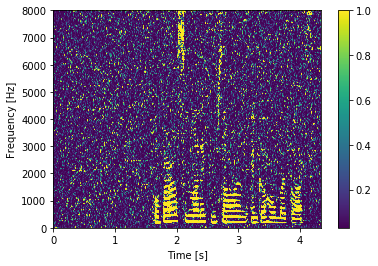

In [6]:
plot_spp(w_P, white.duration_s)

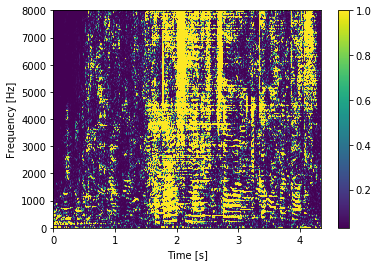

In [7]:
plot_spp(b_P, babble.duration_s)

### 1.3 Plot the estimated noise PSD as a spectrogram

In [8]:
def plot_mag_square_db(stft, duration_s, min_freq = 0, max_freq = 8000, limit=True, vmin=-60, vmax=30):
    fig, ax = plt.subplots(1)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    
    if limit:
        pwr = np.maximum(np.abs(stft.T) ** 2, 10 ** (-15))
    else:
        pwr = np.abs(stft.T) ** 2
    
    im = ax.imshow(ut.lin_to_db(pwr),
                       cmap='viridis',
                       origin='lower',
                       extent=[0, duration_s, min_freq, max_freq],
                       aspect='auto',
                       vmin=vmin,
                       vmax=vmax)
    fig.colorbar(im)

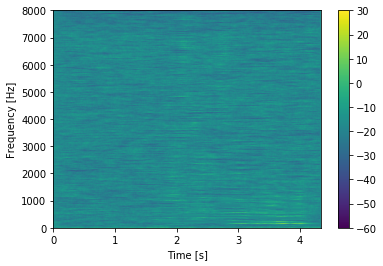

In [9]:
plot_mag_square_db(w_noise_power_estimate, white.duration_s)

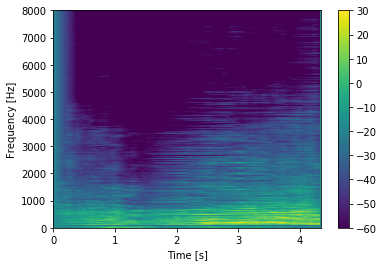

In [10]:
plot_mag_square_db(b_noise_power_estimate, babble.duration_s)

# 2 A priori SNR estimation and Wiener Filtering


In [11]:
def compute_enhanced_spectrum(Y: np.ndarray, noise_power_estimate: np.ndarray, alpha=.5, G_min=0):
    
    L, K = Y.shape
    
    
    # a priori snr
    xi = np.ones((L, K))
    
    # enhanced estimated spectrum
    S_hat = np.zeros((L + 1, K))
    
    # wiener filter
    G = np.ones((L, K))
    
    for k in range(K):
        for l in range(L):
            a = np.abs(S_hat[l - 1, k]) ** 2 / noise_power_estimate[l - 1, k]
            b = (np.abs(Y[l, k]) ** 2 / noise_power_estimate[l, k]) - 1
            
            
            xi[l, k] = alpha * a + (1 - alpha) * np.maximum(b, 0)
            
            a = xi[l, k] / (1 + xi[l, k])
            G[l, k] = np.maximum(a, G_min)
            
            S_hat[l, k] = G[l, k] * Y[l, k]
            
    return S_hat

b_enhanced_spectrum = compute_enhanced_spectrum(b_stft, b_noise_power_estimate, alpha=.5, G_min=0)
w_enhanced_spectrum = compute_enhanced_spectrum(w_stft, w_noise_power_estimate, alpha=.5, G_min=0)

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


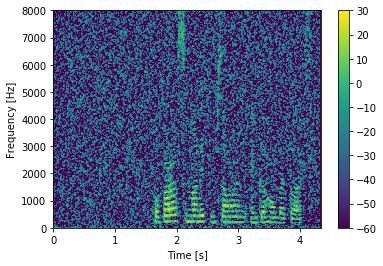

In [12]:
plot_mag_square_db(w_enhanced_spectrum, white.duration_s)

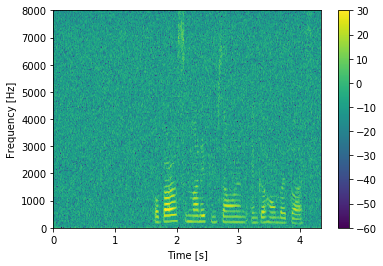

In [13]:
plot_mag_square_db(w_stft, white.duration_s)

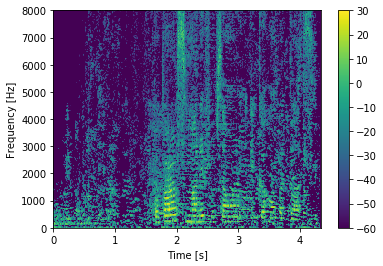

In [14]:
plot_mag_square_db(b_enhanced_spectrum, white.duration_s)

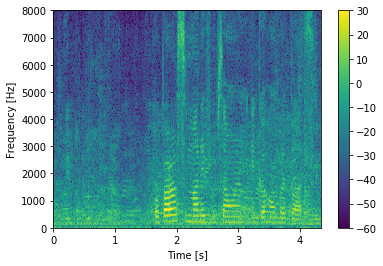

In [15]:
plot_mag_square_db(b_stft, white.duration_s)

# 3 Parameter tuning

In [16]:
def synthesize(stft, fs = 16000, frame_length_ms = 32, frame_shift_ms = 16):
    w = np.sqrt(ss.get_window('hann', ut.ms_to_idx(frame_length_ms, fs), fftbins=True))
    synth = ut.compute_istft(stft, fs, frame_shift_ms, w)
    return synth

## Synthesize the enhanced signals

In [17]:
w_enhanced_spectrum = compute_enhanced_spectrum(w_stft, w_noise_power_estimate)
w_enhanced_synth = synthesize(w_enhanced_spectrum)
w_enhanced_synth.play()

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


In [18]:
white.play()

In [19]:
b_enhanced_spectrum = compute_enhanced_spectrum(b_stft, b_noise_power_estimate)
b_enhanced_synth = synthesize(b_enhanced_spectrum)
b_enhanced_synth.play()

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


In [20]:
babble.play()

In [21]:
def run_parameter_tuning_experiment(stft, noise_power_estimate, duration_s, alpha = .5, G_min = 0):
    # compute enhanced spectrum
    enhanced_spectrum = compute_enhanced_spectrum(stft, noise_power_estimate, alpha, G_min)
    # plot enhanced spectrum
    plot_mag_square_db(enhanced_spectrum, duration_s)
    # synthesize
    synth = synthesize(enhanced_spectrum)
    # play
    synth.play()

## Playing with alpha

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


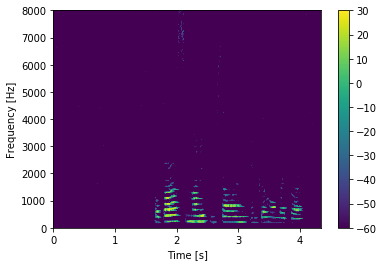

In [22]:
run_parameter_tuning_experiment(w_stft, w_noise_power_estimate, white.duration_s, alpha=.9999)

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


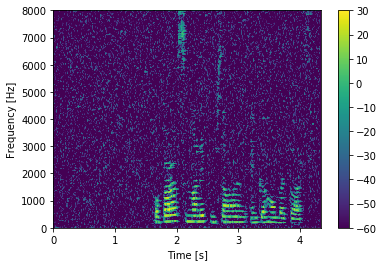

In [23]:
run_parameter_tuning_experiment(w_stft, w_noise_power_estimate, white.duration_s, alpha=.99)

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


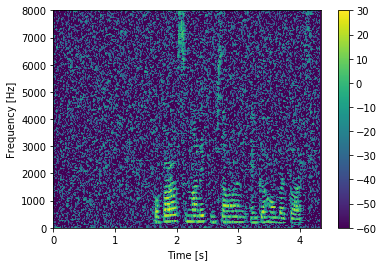

In [24]:
run_parameter_tuning_experiment(w_stft, w_noise_power_estimate, white.duration_s, alpha=.9)

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


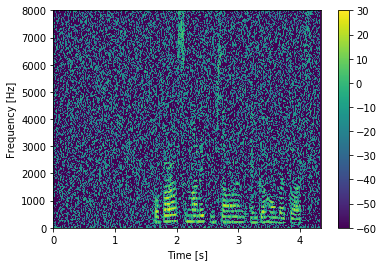

In [25]:
run_parameter_tuning_experiment(w_stft, w_noise_power_estimate, white.duration_s, alpha=0.0)

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


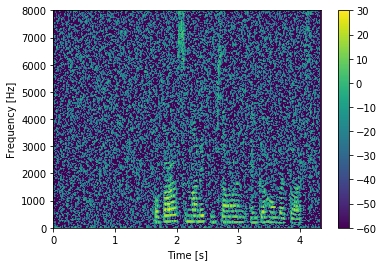

In [26]:
run_parameter_tuning_experiment(w_stft, w_noise_power_estimate, white.duration_s, alpha=0.33)

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


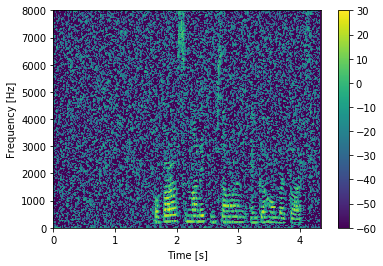

In [27]:
run_parameter_tuning_experiment(w_stft, w_noise_power_estimate, white.duration_s, alpha=0.66)

## Playing with G_min

../src/utils/conversion.py:73: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


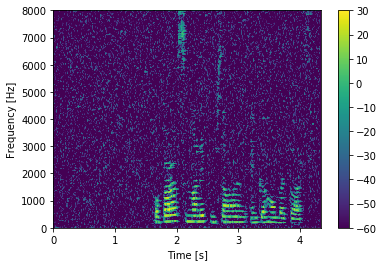

In [28]:
run_parameter_tuning_experiment(w_stft,
                                w_noise_power_estimate,
                                white.duration_s,
                                alpha=.99, G_min=ut.lin_to_db(0))

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


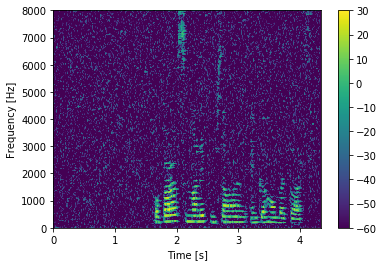

In [29]:
run_parameter_tuning_experiment(w_stft,
                                w_noise_power_estimate,
                                white.duration_s,
                                alpha=.99, G_min=ut.db_to_lin(-100000))

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


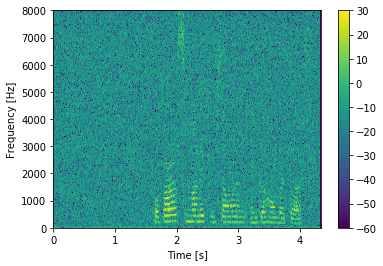

In [30]:
run_parameter_tuning_experiment(w_stft,
                                w_noise_power_estimate,
                                white.duration_s,
                                alpha=.99, G_min=ut.db_to_lin(0.1))

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


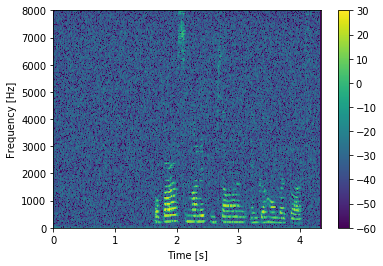

In [31]:
run_parameter_tuning_experiment(w_stft,
                                w_noise_power_estimate,
                                white.duration_s,
                                alpha=.99, G_min=ut.db_to_lin(-10))

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


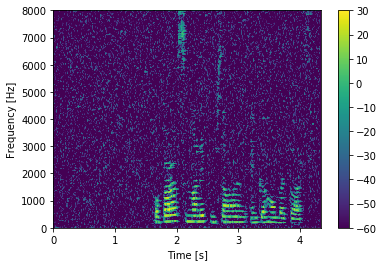

In [32]:
run_parameter_tuning_experiment(w_stft,
                                w_noise_power_estimate,
                                white.duration_s,
                                alpha=.99, G_min=ut.db_to_lin(-100))

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


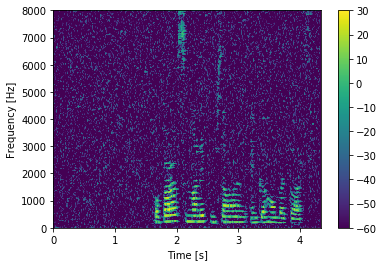

In [33]:
run_parameter_tuning_experiment(w_stft,
                                w_noise_power_estimate,
                                white.duration_s,
                                alpha=.99, G_min=ut.db_to_lin(-1000))

/home/p0w3r/bin/miniconda3/envs/mms/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Successfully loaded audio signal!


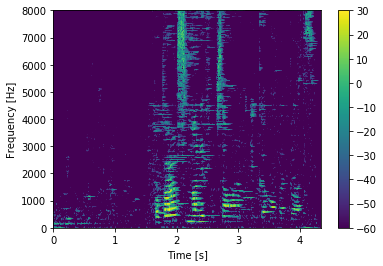

In [34]:
run_parameter_tuning_experiment(b_stft,
                                b_noise_power_estimate,
                                white.duration_s,
                                alpha=.999, G_min=ut.db_to_lin(-1000))

In [35]:
babble.play()

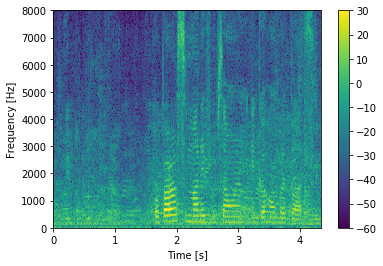

In [36]:
plot_mag_square_db(b_stft, babble.duration_s)

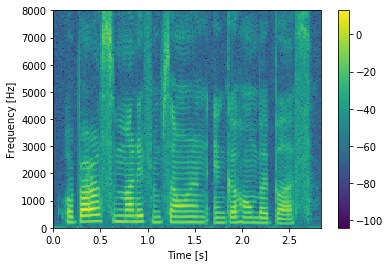

In [37]:
plot_mag_square_db(c_stft, clean.duration_s, vmin=None, vmax=None)

In [38]:
clean.play()